# Strategy 3
A follow through from Strategy 2. But with more specific parameter tuning

In [1]:
# DO NOT RUN UNTIL CHANGES TO DEPENDENCIES 
# pip freeze > requirements.txt

In [1]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))  # adds project root


## Imports

In [2]:
import pandas as pd
import yfinance as yf
from src.functions.plot_position import plot_positions_ma
from src.functions.plot_position import plot_positions_vb
import numpy as np
from src.functions.position_VB import positionVB
import plotly.express as px
from src.functions.plot_position import plot_positions_2mas
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


## Data Loading

In [3]:
file_path = "../data/data1_2023_Q3.parquet"

dataQ3 = pd.read_parquet(file_path, engine="fastparquet")
dataQ3

,datetime,NQ,SP
0,2023-07-03 09:31:00,15187.069,4442.692
1,2023-07-03 09:32:00,15204.149,4443.182
2,2023-07-03 09:33:00,15205.739,4444.906
3,2023-07-03 09:34:00,15203.729,4446.687
4,2023-07-03 09:35:00,15200.169,4446.889
...,...,...,...
25143,2023-09-29 15:56:00,14703.129,4285.614
25144,2023-09-29 15:57:00,14705.529,4285.382
25145,2023-09-29 15:58:00,14723.299,4290.132
25146,2023-09-29 15:59:00,14715.569,4288.376


## Analysing Falls

In [4]:
import numpy as np
import pandas as pd

p = pd.to_numeric(dataQ3["SP"], errors="coerce").to_numpy()
n = len(p)

fwd15 = pd.Series(p).rolling(15).mean().shift(-14).to_numpy()

falls = []
i = 1

while i < n - 15:
    if not (np.isfinite(p[i]) and np.isfinite(p[i-1]) and np.isfinite(fwd15[i])):
        i += 1
        continue

    # start fall on negative return
    if p[i] < p[i-1]:
        start = i - 1
        peak = p[start]
        i += 1

        # wait for positive returns; decide stop/continue using fwd15 at that time
        while i < n - 15:
            if not (np.isfinite(p[i]) and np.isfinite(p[i-1]) and np.isfinite(fwd15[i])):
                i += 1
                continue

            if p[i] > p[i-1]:  # bounce point
                if p[i] <= fwd15[i]:  # stop fall here
                    trough = p[i]
                    falls.append((i - start, trough - peak))
                    i += 1
                    break
                # else: fall continues; keep waiting for next positive return

            i += 1
    else:
        i += 1

falls_df = pd.DataFrame(falls, columns=["duration_min", "max_fall"])


In [6]:
### DUPLICATE LOGIC ### THIS CELL IS REPLACED BY PARAMETER TUNING INSIDE THE NEXT CELL ###

import numpy as np

dataQ3['SP_SMA60'] = dataQ3['SP'].rolling(window = 60, min_periods = 30).mean()
dataQ3['SP_SMA60'] = dataQ3['SP_SMA60'].where(~dataQ3['SP'].isna(), np.nan)
dataQ3['SP_STD60'] = dataQ3['SP'].rolling(window = 60, min_periods = 30).std()

SP = dataQ3["SP"].to_numpy()
SMA60 = dataQ3["SP_SMA60"].to_numpy()
STD60 = dataQ3["SP_STD60"].to_numpy()

freq = falls_df["duration_min"].value_counts().sort_index()
cdf = freq.cumsum() / freq.sum()

D1 = int(cdf[cdf >= 0.50].index[0])
D2 = int(cdf[cdf >= 0.95].index[0])

z = (SP - SMA60) / np.where(STD60 ==0, np.nan, STD60)

# since falls_df has no z_min, use global |z| quantiles as band multipliers
z_abs = np.abs(z[np.isfinite(z)])

k1 = float(np.nanquantile(z_abs, 0.80))
k2 = float(np.nanquantile(z_abs, 0.90))
k3 = float(np.nanquantile(z_abs, 0.97))

k1, k2, k3 = sorted([k1, k2, k3])
k1, k2, k3, D1 , D2

(1.7380303619392508, 2.17030533882155, 2.905933452350645, 3, 28)

In [7]:
### NEEDED ONCE ###
dataQ3 = dataQ3.set_index("datetime")
dataQ3.index

DatetimeIndex(['2023-07-03 09:31:00', '2023-07-03 09:32:00',
               '2023-07-03 09:33:00', '2023-07-03 09:34:00',
               '2023-07-03 09:35:00', '2023-07-03 09:36:00',
               '2023-07-03 09:37:00', '2023-07-03 09:38:00',
               '2023-07-03 09:39:00', '2023-07-03 09:40:00',
               ...
               '2023-09-29 15:51:00', '2023-09-29 15:52:00',
               '2023-09-29 15:53:00', '2023-09-29 15:54:00',
               '2023-09-29 15:55:00', '2023-09-29 15:56:00',
               '2023-09-29 15:57:00', '2023-09-29 15:58:00',
               '2023-09-29 15:59:00', '2023-09-29 16:00:00'],
              dtype='datetime64[us]', name='datetime', length=25148, freq=None)

## Original Strategy 02 (02)

In [8]:
### FLIPPED BY DESIGN
import numpy as np
import pandas as pd

# Build symmetric volatility bands around SMA60 using STD60-scaled multipliers k1/k2/k3
dataQ3["upper_1"] = dataQ3["SP_SMA60"] + k1 * dataQ3["SP_STD60"]
dataQ3["upper_2"] = dataQ3["SP_SMA60"] + k2 * dataQ3["SP_STD60"]
dataQ3["upper_3"] = dataQ3["SP_SMA60"] + k3 * dataQ3["SP_STD60"]

dataQ3["lower_1"] = dataQ3["SP_SMA60"] - k1 * dataQ3["SP_STD60"]
dataQ3["lower_2"] = dataQ3["SP_SMA60"] - k2 * dataQ3["SP_STD60"]
dataQ3["lower_3"] = dataQ3["SP_SMA60"] - k3 * dataQ3["SP_STD60"]

# Pull numpy arrays for speed inside the loop
SP  = dataQ3["SP"].to_numpy()          # price
SMA = dataQ3["SP_SMA60"].to_numpy()    # mean reference (SMA60)

U1 = dataQ3["upper_1"].to_numpy()      # inner upper band (k1)
U2 = dataQ3["upper_2"].to_numpy()      # outer upper band (k2)
L1 = dataQ3["lower_1"].to_numpy()      # inner lower band (k1)
L2 = dataQ3["lower_2"].to_numpy()      # outer lower band (k2)

n = len(dataQ3)

# Outputs: position (+1/-1/0) and regime flag (0=MR, 1=MOM)
pos    = np.zeros(n, dtype=np.int8)
regime = np.zeros(n, dtype=np.int8)

# State variables
mode    = 0        # 0 = mean-reversion mode, 1 = momentum mode
persist = 0        # counts consecutive bars spent below L1
D1      = 5        # persistence threshold required to confirm downside persistence

for t in range(1, n):

    # If any required value is missing at t-1, force flat and carry regime state
    if not np.isfinite([SP[t-1], SMA[t-1], U1[t-1], L1[t-1], U2[t-1], L2[t-1]]).all():
        pos[t] = 0
        regime[t] = mode
        continue

    # Update persistence counter: increment while price stays below L1, else reset to 0
    persist = persist + 1 if SP[t-1] < L1[t-1] else 0

    # Regime switch: MR -> MOM when price is deeply below L2 AND downside has persisted for D1 bars
    if mode == 0 and SP[t-1] < L2[t-1] and persist >= D1:
        mode = 1
        pos[t] = 1
        regime[t] = mode
        continue

    # # Regime switch: MOM -> MR when price re-enters the inner band region [L1, U1]
    # if mode == 1 and L1[t-1] <= SP[t-1] <= U1[t-1]:
    #     mode = 0
    #     pos[t] = 0
    #     persist = 0
    #     regime[t] = mode
    #     continue
    if mode == 1 and ((pos[t-1] == 1 and SP[t-1] <= SMA[t-1]) or (pos[t-1] == -1 and SP[t-1] >= SMA[t-1])):
        mode = 0
        pos[t] = 0
        persist = 0
        regime[t] = mode
        continue

    # Mean-reversion logic (only when mode == 0)
    if mode == 0:

        # If currently flat, open MR position on band breach (contrarian to breach direction)
        if pos[t-1] == 0:
            if SP[t-1] < L1[t-1]:
                pos[t] = -1
            elif SP[t-1] > U1[t-1]:
                pos[t] = 1
            else:
                pos[t] = 0

        # If in an MR trade, hold until price crosses back through the SMA (mean)
        else:
            if (pos[t-1] == -1 and SP[t-1] >= SMA[t-1]) or \
               (pos[t-1] == 1 and SP[t-1] <= SMA[t-1]):
                pos[t] = 0
            else:
                pos[t] = pos[t-1]

    # Momentum logic (only when mode == 1): maintain the current position until regime exit
    else:
        pos[t] = pos[t-1]

    # Record regime state at time t
    regime[t] = mode

# Save results back to the dataframe
dataQ3["position_3"] = pos
dataQ3["regime_3"]   = regime


In [13]:
dataQ3.head()

,NQ,SP,SP_SMA60,SP_STD60,upper_1,upper_2,upper_3,lower_1,lower_2,lower_3,position_3,regime_3
datetime,,,,,,,,,,,,
2023-07-03 09:31:00,15187.069,4442.692,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2023-07-03 09:32:00,15204.149,4443.182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2023-07-03 09:33:00,15205.739,4444.906,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2023-07-03 09:34:00,15203.729,4446.687,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2023-07-03 09:35:00,15200.169,4446.889,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0


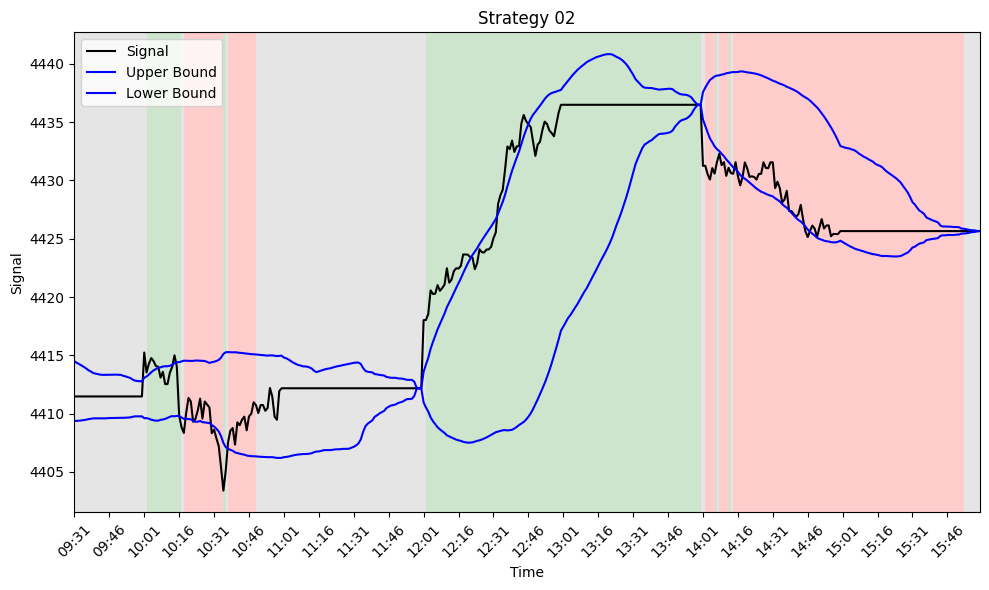

<Axes: title={'center': 'Strategy 02'}, xlabel='Time', ylabel='Signal'>

In [16]:
plot_positions_vb(
    data_plot=dataQ3,
    date_plot="2023-07-07",
    col_signal="SP",
    col_upper="upper_1",
    col_lower="lower_1",
    col_pos="position_3",
    title="Strategy 02"
)


In [17]:

net_profit = np.nansum(dataQ3["position_3"].to_numpy()[:-1] * np.diff(dataQ3["SP"].to_numpy()))
sharpe = np.nanmean(dataQ3["position_3"].to_numpy()[:-1] * np.diff(dataQ3["SP"].to_numpy())) / np.nanstd(dataQ3["position_3"].to_numpy()[:-1] * np.diff(dataQ3["SP"].to_numpy()))

print(net_profit)
print(sharpe)


67.9110000000228
0.002274854986202021


## Param tuning

In [13]:
import numpy as np
### NEEDED ONCE ###
dataQ3 = dataQ3.set_index("datetime")
dataQ3.index


DatetimeIndex(['2023-07-03 09:31:00', '2023-07-03 09:32:00',
               '2023-07-03 09:33:00', '2023-07-03 09:34:00',
               '2023-07-03 09:35:00', '2023-07-03 09:36:00',
               '2023-07-03 09:37:00', '2023-07-03 09:38:00',
               '2023-07-03 09:39:00', '2023-07-03 09:40:00',
               ...
               '2023-09-29 15:51:00', '2023-09-29 15:52:00',
               '2023-09-29 15:53:00', '2023-09-29 15:54:00',
               '2023-09-29 15:55:00', '2023-09-29 15:56:00',
               '2023-09-29 15:57:00', '2023-09-29 15:58:00',
               '2023-09-29 15:59:00', '2023-09-29 16:00:00'],
              dtype='datetime64[us]', name='datetime', length=25148, freq=None)

In [14]:

dataQ3['NQ_SMA60'] = dataQ3['NQ'].rolling(window = 60, min_periods = 30).mean()
dataQ3['NQ_SMA60'] = dataQ3['NQ_SMA60'].where(~dataQ3['NQ'].isna(), np.nan)
dataQ3['NQ_STD60'] = dataQ3['NQ'].rolling(window = 60, min_periods = 30).std()


## 3.

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)

# Group 1 specs
POINT_VALUE = {"SP": 50.0, "NQ": 20.0}
TX_COST = {"SP": 12.0, "NQ": 12.0}  # per 1 contract trade
DATA_DIR = Path("../data")

file_path = next(DATA_DIR.glob("*.parquet"))  # first parquet found
file_path

In [112]:
file_path = "../data/data1_2023_Q3.parquet"

dataQ3 = pd.read_parquet(file_path, engine="fastparquet")
dataQ3

,datetime,NQ,SP
0,2023-07-03 09:31:00,15187.069,4442.692
1,2023-07-03 09:32:00,15204.149,4443.182
2,2023-07-03 09:33:00,15205.739,4444.906
3,2023-07-03 09:34:00,15203.729,4446.687
4,2023-07-03 09:35:00,15200.169,4446.889
...,...,...,...
25143,2023-09-29 15:56:00,14703.129,4285.614
25144,2023-09-29 15:57:00,14705.529,4285.382
25145,2023-09-29 15:58:00,14723.299,4290.132
25146,2023-09-29 15:59:00,14715.569,4288.376


In [113]:
import numpy as np
### NEEDED ONCE ###
dataQ3 = dataQ3.set_index("datetime")
dataQ3.index


DatetimeIndex(['2023-07-03 09:31:00', '2023-07-03 09:32:00',
               '2023-07-03 09:33:00', '2023-07-03 09:34:00',
               '2023-07-03 09:35:00', '2023-07-03 09:36:00',
               '2023-07-03 09:37:00', '2023-07-03 09:38:00',
               '2023-07-03 09:39:00', '2023-07-03 09:40:00',
               ...
               '2023-09-29 15:51:00', '2023-09-29 15:52:00',
               '2023-09-29 15:53:00', '2023-09-29 15:54:00',
               '2023-09-29 15:55:00', '2023-09-29 15:56:00',
               '2023-09-29 15:57:00', '2023-09-29 15:58:00',
               '2023-09-29 15:59:00', '2023-09-29 16:00:00'],
              dtype='datetime64[us]', name='datetime', length=25148, freq=None)

### Summary
- STD window tied to SMA window (no STD_grid)
- k1 / k2 are direct sigma multiples (not quantiles)
- k3 removed (it was unused and conceptually redundant)
- No DataFrame mutation inside tuning
- Objective = net PnL with transaction cost
- Structure preserved (same flow, same state machine)

### 3.1.

In [ ]:

import numpy as np
import pandas as pd
from tqdm import tqdm

FLIP = False  # set False to keep original

# ---------- Preconditions ----------
NQ = dataQ3["NQ"].to_numpy()
n  = len(dataQ3)
TC = 12.0

freq = falls_df["duration_min"].value_counts().sort_index()
cdf  = freq.cumsum() / freq.sum()

# ---------- Grids ----------
D1_grid = np.linspace(0.50, 0.99, 10)

# k are now DIRECT sigma multiples (not quantiles)
k1_grid = np.linspace(1.0, 2.0, 10)
k2_grid = np.linspace(1.5, 3.0, 10)

# SMA and STD are tied
SMA_grid = [60, 120, 240, 480]

best_net_pnl = -np.inf
best_params  = None

# ---------- Grid Search ----------
for SMA_win in SMA_grid:

    SMA   = pd.Series(NQ).rolling(SMA_win, min_periods=SMA_win // 2).mean().to_numpy()
    STD60 = pd.Series(NQ).rolling(SMA_win, min_periods=SMA_win // 2).std().to_numpy()

    for D1_p in tqdm(D1_grid, desc="D1_grid"):

        D1 = int(cdf[cdf >= D1_p].index[0])

        for k1 in tqdm(k1_grid, desc="k1_grid", leave=False):
            for k2 in tqdm(k2_grid, desc="k2_grid", leave=False):

                if not (k1 < k2):
                    continue

                U1 = SMA + k1 * STD60
                U2 = SMA + k2 * STD60
                L1 = SMA - k1 * STD60
                L2 = SMA - k2 * STD60

                pos    = np.zeros(n, dtype=np.int8)
                regime = np.zeros(n, dtype=np.int8)

                mode    = 0
                persist = 0

                # ---------- Main loop ----------
                for t in range(1, n):

                    if not np.isfinite([
                        NQ[t-1], SMA[t-1], STD60[t-1],
                        U1[t-1], U2[t-1], L1[t-1], L2[t-1]
                    ]).all():
                        pos[t] = 0
                        regime[t] = mode
                        continue

                    if STD60[t-1] <= 0:
                        pos[t] = 0
                        regime[t] = mode
                        continue

                    persist = persist + 1 if NQ[t-1] < L1[t-1] else 0

                    # deep oversold → recovery mode
                    if mode == 0 and NQ[t-1] < L2[t-1] and persist >= D1:
                        mode = 1
                        pos[t] = 1
                        regime[t] = mode
                        continue

                    # exit recovery only after mid-band
                    if mode == 1 and NQ[t-1] >= U2[t-1]:
                        mode = 0
                        pos[t] = 0
                        persist = 0
                        regime[t] = mode
                        continue

                    if mode == 0:

                        if pos[t-1] == 0:
                            if NQ[t-1] < L1[t-1]:
                                pos[t] = -1
                            elif NQ[t-1] > U1[t-1]:
                                pos[t] = 1
                            else:
                                pos[t] = 0
                        else:
                            if (pos[t-1] == -1 and NQ[t-1] >= L2[t-1]) or \
                               (pos[t-1] ==  1 and NQ[t-1] <= U2[t-1]):
                                pos[t] = 0
                            else:
                                pos[t] = pos[t-1]
                    else:
                        pos[t] = pos[t-1]

                    regime[t] = mode

                # ---------- Objective ----------
                dS      = np.diff(NQ)
                trades  = np.abs(np.diff(pos))
                r_net   = pos[:-1] * dS - TC * trades
                net_pnl = np.nansum(r_net)

                if net_pnl > best_net_pnl:
                    best_net_pnl = net_pnl
                    best_params  = (SMA_win, D1_p, k1, k2, D1)

# ---------- Re-run strategy once with best params and save ----------
SMA_win, D1_p, k1, k2, D1 = best_params

# recompute SMA / STD ONCE using best window
dataQ3["NQ_SMA"] = dataQ3["NQ"].rolling(SMA_win, min_periods=SMA_win // 2).mean()
dataQ3["NQ_STD"] = dataQ3["NQ"].rolling(SMA_win, min_periods=SMA_win // 2).std()

SMA   = dataQ3["NQ_SMA"].to_numpy()
STD60 = dataQ3["NQ_STD"].to_numpy()

# Change A: slow trend filter (same as tuning)
SMA_slow_win = 4 * SMA_win
dataQ3["NQ_SMA_SLOW"] = dataQ3["NQ"].rolling(SMA_slow_win, min_periods=SMA_slow_win // 2).mean()
SMA_slow = dataQ3["NQ_SMA_SLOW"].to_numpy()
trend = np.sign(np.diff(SMA_slow, prepend=np.nan))  # +1 up, -1 down, 0/na flat

# persistence threshold
D1 = int(cdf[cdf >= D1_p].index[0])

# bands
dataQ3["upper_1"] = SMA + k1 * STD60
dataQ3["upper_2"] = SMA + k2 * STD60
dataQ3["lower_1"] = SMA - k1 * STD60
dataQ3["lower_2"] = SMA - k2 * STD60

U1 = dataQ3["upper_1"].to_numpy()
U2 = dataQ3["upper_2"].to_numpy()
L1 = dataQ3["lower_1"].to_numpy()
L2 = dataQ3["lower_2"].to_numpy()

pos    = np.zeros(n, dtype=np.int8)
regime = np.zeros(n, dtype=np.int8)

mode     = 0
persist  = 0
cooldown = 0
cooldown_bars = 10  # Change B (same as tuning)

# ---------- Main loop ----------
for t in tqdm(range(1, n), desc="main loop", leave=False):

    if not np.isfinite([
        NQ[t-1], SMA[t-1], STD60[t-1],
        U1[t-1], U2[t-1], L1[t-1], L2[t-1],
        trend[t-1]
    ]).all():
        pos[t] = 0
        regime[t] = mode
        cooldown = max(0, cooldown - 1)
        continue

    if STD60[t-1] <= 0:
        pos[t] = 0
        regime[t] = mode
        cooldown = max(0, cooldown - 1)
        continue

    persist = persist + 1 if NQ[t-1] < L1[t-1] else 0

    # deep oversold → recovery mode
    if mode == 0 and NQ[t-1] < L2[t-1] and persist >= D1:
        mode = 1
        pos[t] = 1
        regime[t] = mode
        cooldown = max(0, cooldown - 1)
        continue

    # exit recovery only after mid-band
    if mode == 1 and NQ[t-1] >= U2[t-1]:
        mode = 0
        pos[t] = 0
        persist = 0
        regime[t] = mode
        cooldown = max(0, cooldown - 1)
        continue

    if mode == 0:

        if pos[t-1] == 0:

            # Change B: cooldown gate
            if cooldown > 0:
                pos[t] = 0

            else:
                # Change A: trend gate
                if NQ[t-1] < L1[t-1] and trend[t-1] <= 0:
                    pos[t] = -1
                elif NQ[t-1] > U1[t-1] and trend[t-1] >= 0:
                    pos[t] = 1
                else:
                    pos[t] = 0

        else:
            if (pos[t-1] == -1 and NQ[t-1] >= L2[t-1]) or \
               (pos[t-1] ==  1 and NQ[t-1] <= U2[t-1]):
                pos[t] = 0
            else:
                pos[t] = pos[t-1]

    else:
        pos[t] = pos[t-1]

    # Change B: set cooldown after any position change
    if pos[t] != pos[t-1]:
        cooldown = cooldown_bars
    else:
        cooldown = max(0, cooldown - 1)

    regime[t] = mode

# ---------- Save outputs ----------
dataQ3["position_3"] = (-pos if FLIP else pos)
dataQ3["regime_3"]   = regime



D1_grid:   0%|          | 0/10 [00:00<?, ?it/s]

























































D1_grid:  10%|█         | 1/10 [00:05<00:53,  6.00s/it]

























































D1_grid:  20%|██        | 2/10 [00:11<00:47,  6.00s/it]

























































D1_grid:  30%|███       | 3/10 [00:18<00:42,  6.06s/it]

























































D1_grid:  40%|████      | 4/10 [00:23<00:35,  5.97s/it]

























































D1_grid:  50%|█████     | 5/10 [00:29<00:29,  5.92s/it]

























































D1_grid:  60%|██████    | 6/10 [00:35<00:23,  5.88s/it]

























































D1_grid:  70%|███████   | 7/10 [00:41<00:17,  5.86s/it]

























































D1_grid:  80%|████████  | 8/10 [00:47<00:11,  5.85s/it]


















































### 3.2.

In [76]:
import numpy as np
import pandas as pd
from tqdm import tqdm

FLIP = False  # set False to keep original

# ---------- Preconditions ----------
NQ = dataQ3["NQ"].to_numpy()
n  = len(dataQ3)
TC = 12.0

freq = falls_df["duration_min"].value_counts().sort_index()
cdf  = freq.cumsum() / freq.sum()

# ---------- Grids ----------
D1_grid = np.linspace(0.50, 0.99, 10)

# k are now DIRECT sigma multiples (not quantiles)
k1_grid = np.linspace(1.0, 2.0, 10)
k2_grid = np.linspace(1.5, 3.0, 10)

# SMA and STD are tied
SMA_grid = [60, 120, 240, 480]

# Change B: cooldown (fixed, not tuned)
cooldown_bars = 10

best_net_pnl = -np.inf
best_params  = None

# ---------- Grid Search ----------
for SMA_win in SMA_grid:

    SMA   = pd.Series(NQ).rolling(SMA_win, min_periods=SMA_win // 2).mean().to_numpy()
    STD60 = pd.Series(NQ).rolling(SMA_win, min_periods=SMA_win // 2).std().to_numpy()

    # Change A: slow trend filter (derived from SMA_win)
    SMA_slow_win = 4 * SMA_win
    SMA_slow = pd.Series(NQ).rolling(SMA_slow_win, min_periods=SMA_slow_win // 2).mean().to_numpy()
    trend = np.sign(np.diff(SMA_slow, prepend=np.nan))  # +1 up, -1 down, 0/na flat

    for D1_p in tqdm(D1_grid, desc="D1_grid"):

        D1 = int(cdf[cdf >= D1_p].index[0])

        for k1 in tqdm(k1_grid, desc="k1_grid", leave=False):
            for k2 in tqdm(k2_grid, desc="k2_grid", leave=False):

                if not (k1 < k2):
                    continue

                U1 = SMA + k1 * STD60
                U2 = SMA + k2 * STD60
                L1 = SMA - k1 * STD60
                L2 = SMA - k2 * STD60

                pos    = np.zeros(n, dtype=np.int8)
                regime = np.zeros(n, dtype=np.int8)

                mode      = 0
                persist   = 0
                persist_up = 0
                cooldown  = 0

                # ---------- Main loop ----------
                for t in range(1, n):

                    if not np.isfinite([
                        NQ[t-1], SMA[t-1], STD60[t-1],
                        U1[t-1], U2[t-1], L1[t-1], L2[t-1],
                        trend[t-1]
                    ]).all():
                        pos[t] = 0
                        regime[t] = mode
                        cooldown = max(0, cooldown - 1)
                        continue

                    if STD60[t-1] <= 0:
                        pos[t] = 0
                        regime[t] = mode
                        cooldown = max(0, cooldown - 1)
                        continue

                    # Change B: block flat ticks (prevents churn on repeated prices)
                    if t >= 2 and NQ[t-1] == NQ[t-2]:
                        pos[t] = pos[t-1]
                        regime[t] = mode
                        cooldown = max(0, cooldown - 1)
                        continue

                    # confirmation counters
                    persist    = persist + 1 if NQ[t-1] < L1[t-1] else 0
                    persist_up = persist_up + 1 if NQ[t-1] > U1[t-1] else 0

                    # deep oversold -> recovery mode (allowed regardless of trend filter)
                    if mode == 0 and NQ[t-1] < L2[t-1] and persist >= D1:
                        mode = 1
                        pos[t] = 1
                        regime[t] = mode
                        cooldown = max(0, cooldown - 1)
                        continue

                    # exit recovery only after mid-band
                    if mode == 1 and NQ[t-1] >= U2[t-1]:
                        mode = 0
                        pos[t] = 0
                        persist = 0
                        persist_up = 0
                        regime[t] = mode
                        cooldown = cooldown_bars
                        continue

                    if mode == 0:

                        if pos[t-1] == 0:

                            # strict cooldown gate
                            if cooldown > 0:
                                pos[t] = 0

                            else:
                                # Change A: trend filter on entries
                                # - allow SHORT entries only if trend <= 0
                                # - allow LONG  entries only if trend >= 0
                                if persist >= D1 and trend[t-1] <= 0:
                                    pos[t] = -1
                                elif persist_up >= D1 and trend[t-1] >= 0:
                                    pos[t] = 1
                                else:
                                    pos[t] = 0

                        else:
                            # exits (no flip)
                            exit_now = ((pos[t-1] == -1 and NQ[t-1] >= L2[t-1]) or
                                        (pos[t-1] ==  1 and NQ[t-1] <= U2[t-1]))

                            if exit_now:
                                pos[t] = 0
                                persist = 0
                                persist_up = 0
                                cooldown = cooldown_bars
                            else:
                                pos[t] = pos[t-1]

                    else:
                        pos[t] = pos[t-1]

                    cooldown = max(0, cooldown - 1)
                    regime[t] = mode

                # ---------- Objective ----------
                dS      = np.diff(NQ)
                trades  = np.abs(np.diff(pos))
                r_net   = pos[:-1] * dS - TC * trades
                net_pnl = np.nansum(r_net)

                if net_pnl > best_net_pnl:
                    best_net_pnl = net_pnl
                    best_params  = (SMA_win, D1_p, k1, k2, D1)


D1_grid:   0%|          | 0/10 [00:00<?, ?it/s]


























































D1_grid:  10%|█         | 1/10 [00:06<00:59,  6.57s/it]


























































D1_grid:  20%|██        | 2/10 [00:13<00:53,  6.64s/it]



























































D1_grid:  30%|███       | 3/10 [00:20<00:46,  6.70s/it]


























































D1_grid:  40%|████      | 4/10 [00:26<00:39,  6.66s/it]


























































D1_grid:  50%|█████     | 5/10 [00:32<00:32,  6.54s/it]


























































D1_grid:  60%|██████    | 6/10 [00:39<00:26,  6.52s/it]


























































D1_grid:  70%|███████   | 7/10 [00:45<00:19,  6.51s/it]




























































D1_grid:  80%|████████  | 8/10 [00:53<00:13,  6.93s/it]







































In [77]:
# ---------- Re-run strategy once with best params and save ----------
SMA_win, D1_p, k1, k2, D1 = best_params

# recompute SMA / STD ONCE using best window
dataQ3["NQ_SMA"] = dataQ3["NQ"].rolling(SMA_win, min_periods=SMA_win // 2).mean()
dataQ3["NQ_STD"] = dataQ3["NQ"].rolling(SMA_win, min_periods=SMA_win // 2).std()

SMA   = dataQ3["NQ_SMA"].to_numpy()
STD60 = dataQ3["NQ_STD"].to_numpy()

# Change A: slow trend filter (same as tuning)
SMA_slow_win = 4 * SMA_win
dataQ3["NQ_SMA_SLOW"] = dataQ3["NQ"].rolling(SMA_slow_win, min_periods=SMA_slow_win // 2).mean()
SMA_slow = dataQ3["NQ_SMA_SLOW"].to_numpy()
trend = np.sign(np.diff(SMA_slow, prepend=np.nan))  # +1 up, -1 down, 0/na flat

# persistence threshold
D1 = int(cdf[cdf >= D1_p].index[0])

# bands (sigma-multiple bands)
dataQ3["upper_1"] = SMA + k1 * STD60
dataQ3["upper_2"] = SMA + k2 * STD60
dataQ3["lower_1"] = SMA - k1 * STD60
dataQ3["lower_2"] = SMA - k2 * STD60

U1 = dataQ3["upper_1"].to_numpy()
U2 = dataQ3["upper_2"].to_numpy()
L1 = dataQ3["lower_1"].to_numpy()
L2 = dataQ3["lower_2"].to_numpy()

pos    = np.zeros(n, dtype=np.int8)
regime = np.zeros(n, dtype=np.int8)

mode       = 0
persist    = 0
persist_up = 0
cooldown   = 0

cooldown_bars = 10  # Change B (same as tuning)

# ---------- Main loop ----------
for t in tqdm(range(1, n), desc="main loop", leave=False):

    if not np.isfinite([
        NQ[t-1], SMA[t-1], STD60[t-1],
        U1[t-1], U2[t-1], L1[t-1], L2[t-1],
        trend[t-1]
    ]).all():
        pos[t] = 0
        regime[t] = mode
        cooldown = max(0, cooldown - 1)
        continue

    if STD60[t-1] <= 0:
        pos[t] = 0
        regime[t] = mode
        cooldown = max(0, cooldown - 1)
        continue

    # Change B: block flat ticks (prevents churn on repeated prices)
    if t >= 2 and NQ[t-1] == NQ[t-2]:
        pos[t] = pos[t-1]
        regime[t] = mode
        cooldown = max(0, cooldown - 1)
        continue

    # confirmation counters (same as tuning)
    persist    = persist + 1 if NQ[t-1] < L1[t-1] else 0
    persist_up = persist_up + 1 if NQ[t-1] > U1[t-1] else 0

    # deep oversold -> recovery mode (allowed regardless of trend filter)
    if mode == 0 and NQ[t-1] < L2[t-1] and persist >= D1:
        mode = 1
        pos[t] = 1
        regime[t] = mode
        cooldown = max(0, cooldown - 1)
        continue

    # exit recovery only after mid-band
    if mode == 1 and NQ[t-1] >= U2[t-1]:
        mode = 0
        pos[t] = 0
        persist = 0
        persist_up = 0
        regime[t] = mode
        cooldown = cooldown_bars
        continue

    if mode == 0:

        if pos[t-1] == 0:

            # Change B: cooldown gate
            if cooldown > 0:
                pos[t] = 0

            else:
                # Change A: trend filter on entries (same as tuning)
                if persist >= D1 and trend[t-1] <= 0:
                    pos[t] = -1
                elif persist_up >= D1 and trend[t-1] >= 0:
                    pos[t] = 1
                else:
                    pos[t] = 0

        else:
            # exits only (NO FLIP)
            exit_now = ((pos[t-1] == -1 and NQ[t-1] >= L2[t-1]) or
                        (pos[t-1] ==  1 and NQ[t-1] <= U2[t-1]))

            if exit_now:
                pos[t] = 0
                persist = 0
                persist_up = 0
                cooldown = cooldown_bars
            else:
                pos[t] = pos[t-1]

    else:
        pos[t] = pos[t-1]

    cooldown = max(0, cooldown - 1)
    regime[t] = mode

# ---------- Save outputs ----------
dataQ3["position_3"] = (-pos if FLIP else pos)
dataQ3["regime_3"]   = regime


In [78]:

net_profit = np.nansum(dataQ3["position_3"].to_numpy()[:-1] * np.diff(dataQ3["NQ"].to_numpy()))
sharpe = np.nanmean(dataQ3["position_3"].to_numpy()[:-1] * np.diff(dataQ3["NQ"].to_numpy())) / np.nanstd(dataQ3["position_3"].to_numpy()[:-1] * np.diff(dataQ3["NQ"].to_numpy()))

print(net_profit)
print(sharpe)

132.8719999999994
0.01608408538125125


In [88]:
# Diagnostics: robust trade table (auto-picks your time column)
time_col = "datetime" if "datetime" in dataQ3.columns else ("time" if "time" in dataQ3.columns else None)

base_cols = ["NQ","NQ_SMA","NQ_STD","upper_1","upper_2","lower_1","lower_2","position_3","regime_3"]
cols = ([time_col] if time_col else []) + [c for c in base_cols if c in dataQ3.columns]
df = dataQ3[cols].copy()

NQ   = df["NQ"].to_numpy()
pos  = df["position_3"].to_numpy()
SMA  = df["NQ_SMA"].to_numpy()
STD  = df["NQ_STD"].to_numpy()
U1   = df["upper_1"].to_numpy()
U2   = df["upper_2"].to_numpy()
L1   = df["lower_1"].to_numpy()
L2   = df["lower_2"].to_numpy()
mode = df["regime_3"].to_numpy()

# trend (only if you have SMA_win defined; else set trend = nan)
try:
    SMA_slow = pd.Series(NQ).rolling(4*SMA_win, min_periods=(4*SMA_win)//2).mean().to_numpy()
    trend = np.sign(np.diff(SMA_slow, prepend=np.nan))
except NameError:
    trend = np.full_like(NQ, np.nan, dtype=float)

chg = np.diff(pos, prepend=0)
idx = np.where(chg != 0)[0]

out = pd.DataFrame({
    "t": idx,
    "time": (df[time_col].iloc[idx].to_numpy() if time_col else idx),
    "pos_prev": np.r_[0, pos[idx[:-1]]],
    "pos_new": pos[idx],
    "trade_size": chg[idx],
    "mode": mode[idx],
    "trend": trend[idx],
    "price": NQ[idx],
    "z": (NQ[idx] - SMA[idx]) / np.where(STD[idx] == 0, np.nan, STD[idx]),
    "p-L1": NQ[idx] - L1[idx],
    "p-L2": NQ[idx] - L2[idx],
    "p-U1": NQ[idx] - U1[idx],
    "p-U2": NQ[idx] - U2[idx],
    "STD": STD[idx],
    "dS_1": np.r_[np.nan, np.diff(NQ)][idx],
    "dS_5": pd.Series(NQ).diff(5).to_numpy()[idx],
})

print("time_col =", time_col)
print("num_trades =", len(out))
display(out)


time_col = None
num_trades = 6


,t,time,pos_prev,pos_new,trade_size,mode,trend,price,z,p-L1,p-L2,p-U1,p-U2,STD,dS_1,dS_5
0,1899,1899,0,-1,-1,0,-1.0,14977.919,-1.842232,3.170239,10.719986,-253.521172,-261.070920,67.947726,2.250,-27.640
1,1900,1900,-1,0,1,0,-1.0,14950.627,-2.118310,-16.139924,-8.323188,-281.908943,-289.725678,70.350623,-27.292,-31.992
2,2559,2559,0,1,1,1,1.0,15028.219,-2.518568,-9.253687,-7.620812,-64.771446,-66.404322,14.695877,-2.520,-9.060
3,2654,2654,1,0,-1,1,-1.0,15071.069,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000
4,8574,8574,0,1,1,1,-1.0,15330.499,-1.890783,-0.059260,3.417025,-118.252940,-121.729225,31.286563,4.740,-10.470
5,8624,8624,1,0,-1,0,-1.0,15393.229,1.603807,74.261095,76.623520,-6.061361,-8.423787,21.261827,-7.260,9.790


In [79]:
# Analyze trades
pos = dataQ3["position_3"].to_numpy()
px  = dataQ3["NQ"].to_numpy()

# use datetime index if present; else fallback to row number
ts = dataQ3.index.to_numpy() if getattr(dataQ3.index, "dtype", None) is not None else np.arange(len(dataQ3))

dpos = np.diff(pos)
trade_idx = np.where(dpos != 0)[0] + 1  # t where position changes

trades_df = pd.DataFrame({
    "t": trade_idx,
    "time": ts[trade_idx],
    "pos_prev": pos[trade_idx - 1],
    "pos_new":  pos[trade_idx],
    "trade_size": dpos[trade_idx - 1],          # +1 buy, -1 sell, +2/-2 flip
    "price": px[trade_idx],
    "dS_1": px[np.minimum(trade_idx + 1, len(px)-1)] - px[trade_idx],
    "dS_5": px[np.minimum(trade_idx + 5, len(px)-1)] - px[trade_idx],
})

print("num_trades =", len(trades_df))
print(trades_df.head(30).to_string(index=False))


num_trades = 6
   t                time  pos_prev  pos_new  trade_size     price    dS_1   dS_5
1899 2023-07-10 09:55:00         0       -1          -1 14977.919 -27.292 -6.690
1900 2023-07-10 09:56:00        -1        0           1 14950.627   3.612 20.602
2559 2023-07-11 14:25:00         0        1           1 15028.219  -0.170  9.960
2654 2023-07-11 16:00:00         1        0          -1 15071.069   0.000  0.000
8574 2023-08-02 12:13:00         0        1           1 15330.499   2.420 18.770
8624 2023-08-02 13:03:00         1        0          -1 15393.229  -1.810 -3.020


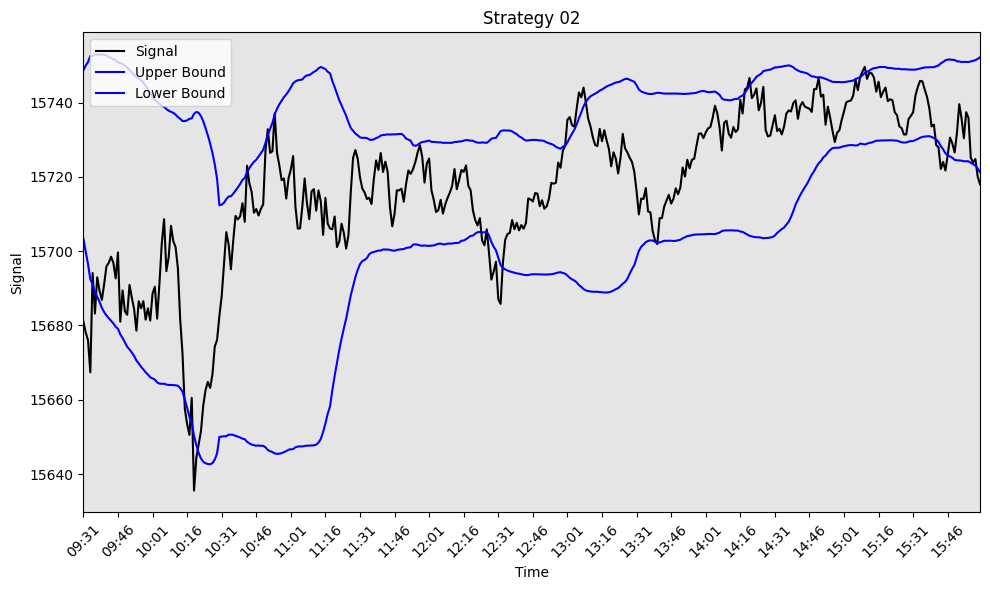

NQ             float64
SP             float64
NQ_SMA60       float64
NQ_STD60       float64
NQ_SMA         float64
NQ_STD         float64
upper_1        float64
upper_2        float64
lower_1        float64
lower_2        float64
position_3        int8
regime_3          int8
NQ_SMA_SLOW    float64
dtype: object

In [89]:
plot_positions_vb(
    data_plot=dataQ3,
    date_plot="2023-08-01",
    col_signal="NQ",
    col_upper="upper_1",
    col_lower="lower_1",
    col_pos="position_3",
    title="Strategy 02"
)
dataQ3.dtypes

### 3.3.

In [107]:
# APPLY MASK
def add_group1_masks(index: pd.DatetimeIndex) -> pd.DataFrame:
    """
    Creates masks required by the assignment for Group 1:
    - NaN windows for calculations: 9:31-9:40 and 15:51-16:00
    - no trading: 9:31-9:55
    - flat from: 15:40 to end (no overnight)
    """
    t = index.time

    nan_morning = (t >= pd.to_datetime("09:31").time()) & (t <= pd.to_datetime("09:40").time())
    nan_close   = (t >= pd.to_datetime("15:51").time()) & (t <= pd.to_datetime("16:00").time())
    mask_nan = nan_morning | nan_close

    no_trade = (t >= pd.to_datetime("09:31").time()) & (t <= pd.to_datetime("09:55").time())
    flat_from = (t >= pd.to_datetime("15:40").time())

    return pd.DataFrame(
        {"mask_nan": mask_nan, "mask_no_trade": no_trade, "mask_flat_from": flat_from},
        index=index
    )

masks = add_group1_masks(df.index)
masks.head()

# build masks once
masks = add_group1_masks(dataQ3.index)

# 1) Enforce NaN windows at the DATA level (affects SMA/STD/trend automatically)
dataQ3.loc[masks["mask_nan"], "NQ"] = np.nan

# 2) Add control columns the strategy can read (no logic changes)
dataQ3["mask_no_trade"]  = masks["mask_no_trade"].astype(bool)
dataQ3["mask_flat_from"] = masks["mask_flat_from"].astype(bool)


In [108]:
# ===========================
# PARAMETER TUNING 
# ===========================
import numpy as np
import pandas as pd
from tqdm import tqdm

FLIP = False  # set False to keep original

# ---------- Preconditions ----------
NQ = dataQ3["NQ"].to_numpy()
n  = len(dataQ3)
TC = 12.0

freq = falls_df["duration_min"].value_counts().sort_index()
cdf  = freq.cumsum() / freq.sum()

# ---------- Grids ----------
D1_grid = np.linspace(0.50, 0.99, 10)

# k are DIRECT sigma multiples
k1_grid = np.linspace(0.6, 1.6, 10)     # tighter -> more touches
k2_grid = np.linspace(1.0, 2.4, 10)

# SMA and STD are tied
SMA_grid = [60, 120, 240, 480]

# Change B: cooldown (fixed, reduced)
cooldown_bars = 3

best_net_pnl = -np.inf
best_params  = None

# ---------- Grid Search ----------
for SMA_win in SMA_grid:

    SMA   = pd.Series(NQ).rolling(SMA_win, min_periods=SMA_win // 2).mean().to_numpy()
    STD   = pd.Series(NQ).rolling(SMA_win, min_periods=SMA_win // 2).std().to_numpy()

    for D1_p in tqdm(D1_grid, desc="D1_grid"):

        D1 = int(cdf[cdf >= D1_p].index[0])
        D_entry = max(1, D1 // 4)  # KEY: lighter confirmation for entries

        for k1 in tqdm(k1_grid, desc="k1_grid", leave=False):
            for k2 in tqdm(k2_grid, desc="k2_grid", leave=False):

                if not (k1 < k2):
                    continue

                U1 = SMA + k1 * STD
                U2 = SMA + k2 * STD
                L1 = SMA - k1 * STD
                L2 = SMA - k2 * STD

                pos    = np.zeros(n, dtype=np.int8)
                regime = np.zeros(n, dtype=np.int8)

                mode      = 0
                persist_dn = 0
                persist_up = 0
                cooldown  = 0

                # ---------- Main loop ----------
                for t in range(1, n):

                    if not np.isfinite([NQ[t-1], SMA[t-1], STD[t-1], U1[t-1], U2[t-1], L1[t-1], L2[t-1]]).all():
                        pos[t] = 0
                        regime[t] = mode
                        cooldown = max(0, cooldown - 1)
                        continue

                    if STD[t-1] <= 0:
                        pos[t] = 0
                        regime[t] = mode
                        cooldown = max(0, cooldown - 1)
                        continue

                    # avoid "flat tick" churn
                    if t >= 2 and NQ[t-1] == NQ[t-2]:
                        pos[t] = pos[t-1]
                        regime[t] = mode
                        cooldown = max(0, cooldown - 1)
                        continue

                    # confirmations
                    persist_dn = persist_dn + 1 if NQ[t-1] < L1[t-1] else 0
                    persist_up = persist_up + 1 if NQ[t-1] > U1[t-1] else 0

                    # deep oversold => recovery mode (uses D1, not D_entry)
                    if mode == 0 and NQ[t-1] < L2[t-1] and persist_dn >= D1:
                        mode = 1
                        pos[t] = 1
                        regime[t] = mode
                        cooldown = max(0, cooldown - 1)
                        continue

                    # exit recovery when mean-reversion confirmed (cross U1)
                    if mode == 1 and NQ[t-1] >= U1[t-1]:
                        mode = 0
                        pos[t] = 0
                        persist_dn = 0
                        persist_up = 0
                        regime[t] = mode
                        cooldown = cooldown_bars
                        continue

                    if mode == 0:

                        if pos[t-1] == 0:

                            if cooldown > 0:
                                pos[t] = 0
                            else:
                                # contrarian entries with lighter confirmation
                                if persist_dn >= D_entry:
                                    pos[t] = 1        # below L1 => LONG
                                elif persist_up >= D_entry:
                                    pos[t] = -1       # above U1 => SHORT
                                else:
                                    pos[t] = 0

                        else:
                            # exits back to 0, no flip
                            exit_now = ((pos[t-1] ==  1 and NQ[t-1] >= U2[t-1]) or
                                        (pos[t-1] == -1 and NQ[t-1] <= L2[t-1]))

                            if exit_now:
                                pos[t] = 0
                                persist_dn = 0
                                persist_up = 0
                                cooldown = cooldown_bars
                            else:
                                pos[t] = pos[t-1]

                    else:
                        # recovery mode: hold
                        pos[t] = pos[t-1]

                    cooldown = max(0, cooldown - 1)
                    regime[t] = mode

                # ---------- Objective ----------
                dS      = np.diff(NQ)
                trades  = np.abs(np.diff(pos))
                r_net   = pos[:-1] * dS - TC * trades
                net_pnl = np.nansum(r_net)

                if net_pnl > best_net_pnl:
                    best_net_pnl = net_pnl
                    best_params  = (SMA_win, D1_p, k1, k2)

print("best_net_pnl:", best_net_pnl)
print("best_params :", best_params)

# ===========================
# RE-RUN WITH BEST PARAMS 
# ===========================
import numpy as np
import pandas as pd
from tqdm import tqdm

FLIP = False

NQ = dataQ3["NQ"].to_numpy()
n  = len(dataQ3)
TC = 12.0

freq = falls_df["duration_min"].value_counts().sort_index()
cdf  = freq.cumsum() / freq.sum()

cooldown_bars = 3

SMA_win, D1_p, k1, k2 = best_params

# compute SMA/STD ONCE (and save to df for plots)
dataQ3["NQ_SMA"] = dataQ3["NQ"].rolling(SMA_win, min_periods=SMA_win // 2).mean()
dataQ3["NQ_STD"] = dataQ3["NQ"].rolling(SMA_win, min_periods=SMA_win // 2).std()

SMA = dataQ3["NQ_SMA"].to_numpy()
STD = dataQ3["NQ_STD"].to_numpy()

D1      = int(cdf[cdf >= D1_p].index[0])
D_entry = max(1, D1 // 4)

# bands (saved)
dataQ3["upper_1"] = SMA + k1 * STD
dataQ3["upper_2"] = SMA + k2 * STD
dataQ3["lower_1"] = SMA - k1 * STD
dataQ3["lower_2"] = SMA - k2 * STD

U1 = dataQ3["upper_1"].to_numpy()
U2 = dataQ3["upper_2"].to_numpy()
L1 = dataQ3["lower_1"].to_numpy()
L2 = dataQ3["lower_2"].to_numpy()

pos    = np.zeros(n, dtype=np.int8)
regime = np.zeros(n, dtype=np.int8)

mode       = 0
persist_dn = 0
persist_up = 0
cooldown   = 0

for t in tqdm(range(1, n), desc="main loop", leave=False):

    if not np.isfinite([NQ[t-1], SMA[t-1], STD[t-1], U1[t-1], U2[t-1], L1[t-1], L2[t-1]]).all():
        pos[t] = 0
        regime[t] = mode
        cooldown = max(0, cooldown - 1)
        continue

    if STD[t-1] <= 0:
        pos[t] = 0
        regime[t] = mode
        cooldown = max(0, cooldown - 1)
        continue

    if t >= 2 and NQ[t-1] == NQ[t-2]:
        pos[t] = pos[t-1]
        regime[t] = mode
        cooldown = max(0, cooldown - 1)
        continue

    persist_dn = persist_dn + 1 if NQ[t-1] < L1[t-1] else 0
    persist_up = persist_up + 1 if NQ[t-1] > U1[t-1] else 0

    if mode == 0 and NQ[t-1] < L2[t-1] and persist_dn >= D1:
        mode = 1
        pos[t] = 1
        regime[t] = mode
        cooldown = max(0, cooldown - 1)
        continue

    if mode == 1 and NQ[t-1] >= U1[t-1]:
        mode = 0
        pos[t] = 0
        persist_dn = 0
        persist_up = 0
        regime[t] = mode
        cooldown = cooldown_bars
        continue

    if mode == 0:

        if pos[t-1] == 0:

            if cooldown > 0:
                pos[t] = 0
            else:
                if persist_dn >= D_entry:
                    pos[t] = 1
                elif persist_up >= D_entry:
                    pos[t] = -1
                else:
                    pos[t] = 0

        else:
            exit_now = ((pos[t-1] ==  1 and NQ[t-1] >= U2[t-1]) or
                        (pos[t-1] == -1 and NQ[t-1] <= L2[t-1]))

            if exit_now:
                pos[t] = 0
                persist_dn = 0
                persist_up = 0
                cooldown = cooldown_bars
            else:
                pos[t] = pos[t-1]

    else:
        pos[t] = pos[t-1]

    cooldown = max(0, cooldown - 1)
    regime[t] = mode

dataQ3["position_3"] = (-pos if FLIP else pos)
dataQ3["regime_3"]   = regime


D1_grid:   0%|          | 0/10 [00:00<?, ?it/s]





















































D1_grid:  10%|█         | 1/10 [00:06<00:57,  6.42s/it]





















































D1_grid:  20%|██        | 2/10 [00:12<00:50,  6.32s/it]























































D1_grid:  30%|███       | 3/10 [00:18<00:43,  6.28s/it]






















































D1_grid:  40%|████      | 4/10 [00:25<00:37,  6.33s/it]





















































D1_grid:  50%|█████     | 5/10 [00:31<00:31,  6.30s/it]























































D1_grid:  60%|██████    | 6/10 [00:38<00:25,  6.42s/it]























































D1_grid:  70%|███████   | 7/10 [00:44<00:19,  6.41s/it]























































D1_grid:  80%|████████  | 8/10 [00:50<00:12,  6.37s/it]






















































D1_grid:  90%|███

best_net_pnl: -380.05599999999686
best_params : (480, np.float64(0.99), np.float64(1.488888888888889), np.float64(2.088888888888889))


In [109]:

net_profit = np.nansum(dataQ3["position_3"].to_numpy()[:-1] * np.diff(dataQ3["NQ"].to_numpy()))
sharpe = np.nanmean(dataQ3["position_3"].to_numpy()[:-1] * np.diff(dataQ3["NQ"].to_numpy())) / np.nanstd(dataQ3["position_3"].to_numpy()[:-1] * np.diff(dataQ3["NQ"].to_numpy()))

print(net_profit)
print(sharpe)

363.94400000000314
0.003482570320632876


In [110]:
# Diagnostics: robust trade table (auto-picks your time column)
time_col = "datetime" if "datetime" in dataQ3.columns else ("time" if "time" in dataQ3.columns else None)

base_cols = ["NQ","NQ_SMA","NQ_STD","upper_1","upper_2","lower_1","lower_2","position_3","regime_3"]
cols = ([time_col] if time_col else []) + [c for c in base_cols if c in dataQ3.columns]
df = dataQ3[cols].copy()

NQ   = df["NQ"].to_numpy()
pos  = df["position_3"].to_numpy()
SMA  = df["NQ_SMA"].to_numpy()
STD  = df["NQ_STD"].to_numpy()
U1   = df["upper_1"].to_numpy()
U2   = df["upper_2"].to_numpy()
L1   = df["lower_1"].to_numpy()
L2   = df["lower_2"].to_numpy()
mode = df["regime_3"].to_numpy()

# trend (only if you have SMA_win defined; else set trend = nan)
try:
    SMA_slow = pd.Series(NQ).rolling(4*SMA_win, min_periods=(4*SMA_win)//2).mean().to_numpy()
    trend = np.sign(np.diff(SMA_slow, prepend=np.nan))
except NameError:
    trend = np.full_like(NQ, np.nan, dtype=float)

chg = np.diff(pos, prepend=0)
idx = np.where(chg != 0)[0]

out = pd.DataFrame({
    "t": idx,
    "time": (df[time_col].iloc[idx].to_numpy() if time_col else idx),
    "pos_prev": np.r_[0, pos[idx[:-1]]],
    "pos_new": pos[idx],
    "trade_size": chg[idx],
    "mode": mode[idx],
    "trend": trend[idx],
    "price": NQ[idx],
    "z": (NQ[idx] - SMA[idx]) / np.where(STD[idx] == 0, np.nan, STD[idx]),
    "p-L1": NQ[idx] - L1[idx],
    "p-L2": NQ[idx] - L2[idx],
    "p-U1": NQ[idx] - U1[idx],
    "p-U2": NQ[idx] - U2[idx],
    "STD": STD[idx],
    "dS_1": np.r_[np.nan, np.diff(NQ)][idx],
    "dS_5": pd.Series(NQ).diff(5).to_numpy()[idx],
})

print("time_col =", time_col)
print("num_trades =", len(out))
display(out)


time_col = None
num_trades = 114


,t,time,pos_prev,pos_new,trade_size,mode,trend,price,z,p-L1,p-L2,p-U1,p-U2,STD,dS_1,dS_5
0,730,730,0,-1,-1,0,NaN,15224.839,5.040156,30.030518,32.790234,16.334149,13.574432,4.599527,-6.96,8.75
1,1086,1086,-1,0,1,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,12.014296,NaN,NaN
2,1120,1120,0,1,1,0,-1.0,14986.779,-5.872393,-164.014994,-141.565147,-275.432757,-297.882604,37.416413,-4.12,-38.00
3,1476,1476,1,0,-1,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,77.453329,NaN,NaN
4,1710,1710,0,-1,-1,0,1.0,15201.099,3.254479,173.759705,195.738990,64.677330,42.698045,36.632141,-1.55,1.48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,24359,24359,-1,0,1,0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,49.086281,NaN,NaN
110,24495,24495,0,-1,-1,0,-1.0,14700.279,2.551587,236.038982,271.090147,62.081348,27.030183,58.418608,-4.78,7.22
111,24749,24749,-1,0,1,0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,74.885491,NaN,NaN
112,24783,24783,0,-1,-1,0,1.0,14866.519,2.452589,298.727462,344.201898,73.039520,27.565083,75.790727,-9.24,3.73


### 3.4

In [121]:
# =========================
# PARAMETER TUNING (FASTER, same logic/grids)
# =========================
import numpy as np
import pandas as pd

FLIP = False

# ---------- Preconditions ----------
NQ = dataQ3["NQ"].to_numpy()
n  = len(dataQ3)
TC = 12.0
POINT_VALUE = 20.0  # NQ

# precompute once (was inside every iteration)
dS = np.diff(NQ)

freq = falls_df["duration_min"].value_counts().sort_index()
cdf  = freq.cumsum() / freq.sum()

# ---------- Grids (UNCHANGED) ----------
D1_grid      = np.linspace(0.50, 0.99, 5)
SMA_grid     = [120, 240, 480]
k1_grid      = np.linspace(1.0, 2.0, 5)
k2_grid      = np.linspace(1.5, 3.0, 5)
z_entry_grid = np.linspace(0.8, 1.8, 4)
z_exit_grid  = np.linspace(0.8, 2.0, 4)
z_cap_grid   = [3.0, 4.0, 5.0]

cooldown_bars = 10

best_net_pnl = -np.inf
best_params  = None

# ---------- Grid Search ----------
for SMA_win in SMA_grid:

    SMA = pd.Series(NQ).rolling(SMA_win, min_periods=SMA_win // 2).mean().to_numpy()
    STD = pd.Series(NQ).rolling(SMA_win, min_periods=SMA_win // 2).std().to_numpy()

    SMA_slow_win = 4 * SMA_win
    SMA_slow = pd.Series(NQ).rolling(SMA_slow_win, min_periods=SMA_slow_win // 2).mean().to_numpy()
    trend = np.sign(np.diff(SMA_slow, prepend=np.nan))

    z = (NQ - SMA) / np.where(STD == 0, np.nan, STD)

    for D1_p in D1_grid:

        D_entry = int(cdf[cdf >= D1_p].index[0])
        D_deep  = D_entry

        for k1 in k1_grid:
            for k2 in k2_grid:
                if not (k1 < k2):
                    continue

                U1 = SMA + k1 * STD
                U2 = SMA + k2 * STD
                L1 = SMA - k1 * STD
                L2 = SMA - k2 * STD

                for z_entry in z_entry_grid:
                    for z_exit in z_exit_grid:
                        for z_cap in z_cap_grid:

                            pos = np.zeros(n, dtype=np.int8)

                            mode       = 0
                            cooldown   = 0
                            persist_dn = 0
                            persist_up = 0

                            for t in range(1, n):

                                # fast scalar checks (same meaning as your list-based isfinite)
                                if (not np.isfinite(NQ[t-1]) or not np.isfinite(SMA[t-1]) or not np.isfinite(STD[t-1]) or
                                    not np.isfinite(z[t-1])  or not np.isfinite(U1[t-1])  or not np.isfinite(U2[t-1])  or
                                    not np.isfinite(L1[t-1]) or not np.isfinite(L2[t-1])):
                                    pos[t] = 0
                                    cooldown = cooldown - 1 if cooldown > 0 else 0
                                    continue

                                if STD[t-1] <= 0:
                                    pos[t] = 0
                                    cooldown = cooldown - 1 if cooldown > 0 else 0
                                    continue

                                if t >= 2 and NQ[t-1] == NQ[t-2]:
                                    pos[t] = pos[t-1]
                                    cooldown = cooldown - 1 if cooldown > 0 else 0
                                    continue

                                persist_dn = persist_dn + 1 if NQ[t-1] < L1[t-1] else 0
                                persist_up = persist_up + 1 if NQ[t-1] > U1[t-1] else 0

                                if mode == 0 and (NQ[t-1] < L2[t-1]) and (persist_dn >= D_deep):
                                    mode = 1
                                    pos[t] = 1
                                    cooldown = cooldown - 1 if cooldown > 0 else 0
                                    continue

                                if mode == 1 and (NQ[t-1] >= SMA[t-1] or z[t-1] >= z_exit):
                                    mode = 0
                                    pos[t] = 0
                                    persist_dn = 0
                                    persist_up = 0
                                    cooldown = cooldown_bars
                                    continue

                                if mode == 0:

                                    if pos[t-1] == 0:

                                        if cooldown > 0:
                                            pos[t] = 0
                                        else:
                                            if (persist_dn >= D_entry) and (trend[t-1] <= 0) and (z[t-1] <= -z_entry) and (z[t-1] >= -z_cap):
                                                pos[t] = 1
                                            elif (persist_up >= D_entry) and (trend[t-1] >= 0) and (z[t-1] >=  z_entry) and (z[t-1] <=  z_cap):
                                                pos[t] = -1
                                            else:
                                                pos[t] = 0

                                    else:
                                        if pos[t-1] == 1:
                                            if (NQ[t-1] >= SMA[t-1]) or (z[t-1] >= z_exit):
                                                pos[t] = 0
                                                persist_dn = 0
                                                persist_up = 0
                                                cooldown = cooldown_bars
                                            else:
                                                pos[t] = 1
                                        else:  # pos[t-1] == -1
                                            if (NQ[t-1] <= SMA[t-1]) or (z[t-1] <= -z_exit):
                                                pos[t] = 0
                                                persist_dn = 0
                                                persist_up = 0
                                                cooldown = cooldown_bars
                                            else:
                                                pos[t] = -1

                                else:
                                    pos[t] = pos[t-1]

                                cooldown = cooldown - 1 if cooldown > 0 else 0

                            trades  = np.abs(np.diff(pos))
                            r_net   = POINT_VALUE * (pos[:-1] * dS) - TC * trades
                            net_pnl = np.nansum(r_net)

                            if net_pnl > best_net_pnl:
                                best_net_pnl = net_pnl
                                best_params  = (SMA_win, D1_p, k1, k2, z_entry, z_exit, z_cap, cooldown_bars)

print("best_net_pnl:", best_net_pnl)
print("best_params :", best_params)


KeyboardInterrupt: 

In [140]:
dataQ3.columns

Index(['NQ', 'SP', 'NQ_SMA60', 'NQ_STD60', 'NQ_SMA', 'NQ_STD', 'NQ_SMA_SLOW',
       'upper_1', 'upper_2', 'lower_1', 'lower_2', 'position_3', 'regime_3',
       'z', 'trend'],
      dtype='object')

In [22]:
# =========================
# PARAMETER TUNING (FASTER, same logic, REDUCED GRID as agreed)
# - Remove independent z_exit_grid
# - Use z_exit = z_entry + dz, with small dz grid
# =========================
import numpy as np
import pandas as pd

FLIP = False

# ---------- Preconditions ----------
NQ = dataQ3["NQ"].to_numpy()
n  = len(dataQ3)
TC = 12.0
POINT_VALUE = 20.0  # NQ

# precompute once
dS = np.diff(NQ)

freq = falls_df["duration_min"].value_counts().sort_index()
cdf  = freq.cumsum() / freq.sum()

# ---------- Grids (REDUCED to hit ~4–10 mins) ----------
# Preset B (balanced): ~900–1100 combos after k1<k2
# D1_grid      = [0.55, 0.70, 0.85, 0.95]   # 4
D1_grid  = np.array([0.90, 0.93, 0.95, 0.97])
# SMA_grid     = [120, 240, 480]            # 3
SMA_grid = [360, 480, 600]

# k1_grid      = [1.0, 1.4, 1.8]            # 3
# k2_grid      = [1.8, 2.4, 3.0]            # 3  (k1<k2)
k1_grid  = np.array([0.9, 1.0, 1.1])
k2_grid  = np.array([2.2, 2.4, 2.6])

# z_entry_grid = [0.9, 1.2, 1.5]            # 3
# z_exit_dz_grid = [0.4, 0.8]               # 2  -> z_exit = z_entry + dz
z_entry_grid   = np.array([0.8, 0.9, 1.0])
z_exit_dz_grid = np.array([0.3, 0.4])      # keeps z_exit ≈ 1.1–1.4


# z_cap_grid   = [3.0, 4.0]                 # 2
z_cap_grid = np.array([3.5, 4.0, 4.5])

cooldown_bars = 10

best_net_pnl = -np.inf
best_params  = None

# ---------- Grid Search ----------
for SMA_win in SMA_grid:

    SMA = pd.Series(NQ).rolling(SMA_win, min_periods=SMA_win // 2).mean().to_numpy()
    STD = pd.Series(NQ).rolling(SMA_win, min_periods=SMA_win // 2).std().to_numpy()

    SMA_slow_win = 4 * SMA_win
    SMA_slow = pd.Series(NQ).rolling(SMA_slow_win, min_periods=SMA_slow_win // 2).mean().to_numpy()
    trend = np.sign(np.diff(SMA_slow, prepend=np.nan))

    z = (NQ - SMA) / np.where(STD == 0, np.nan, STD)

    for D1_p in D1_grid:

        D_entry = int(cdf[cdf >= D1_p].index[0])
        D_deep  = D_entry

        for k1 in k1_grid:
            for k2 in k2_grid:
                if not (k1 < k2):
                    continue

                U1 = SMA + k1 * STD
                U2 = SMA + k2 * STD
                L1 = SMA - k1 * STD
                L2 = SMA - k2 * STD

                for z_entry in z_entry_grid:
                    for dz in z_exit_dz_grid:
                        z_exit = z_entry + dz
                        for z_cap in z_cap_grid:

                            pos = np.zeros(n, dtype=np.int8)

                            mode       = 0
                            cooldown   = 0
                            persist_dn = 0
                            persist_up = 0

                            for t in range(1, n):

                                if (not np.isfinite(NQ[t-1]) or not np.isfinite(SMA[t-1]) or not np.isfinite(STD[t-1]) or
                                    not np.isfinite(z[t-1])  or not np.isfinite(U1[t-1])  or not np.isfinite(U2[t-1])  or
                                    not np.isfinite(L1[t-1]) or not np.isfinite(L2[t-1]) or not np.isfinite(trend[t-1])):
                                    pos[t] = 0
                                    cooldown = cooldown - 1 if cooldown > 0 else 0
                                    continue

                                if STD[t-1] <= 0:
                                    pos[t] = 0
                                    cooldown = cooldown - 1 if cooldown > 0 else 0
                                    continue

                                if t >= 2 and NQ[t-1] == NQ[t-2]:
                                    pos[t] = pos[t-1]
                                    cooldown = cooldown - 1 if cooldown > 0 else 0
                                    continue

                                persist_dn = persist_dn + 1 if NQ[t-1] < L1[t-1] else 0
                                persist_up = persist_up + 1 if NQ[t-1] > U1[t-1] else 0

                                # deep oversold -> recovery mode
                                if mode == 0 and (NQ[t-1] < L2[t-1]) and (persist_dn >= D_deep):
                                    mode = 1
                                    pos[t] = 1
                                    cooldown = cooldown - 1 if cooldown > 0 else 0
                                    continue

                                # exit recovery at mean OR z-stop
                                if mode == 1 and (NQ[t-1] >= SMA[t-1] or z[t-1] >= z_exit):
                                    mode = 0
                                    pos[t] = 0
                                    persist_dn = 0
                                    persist_up = 0
                                    cooldown = cooldown_bars
                                    continue

                                if mode == 0:

                                    if pos[t-1] == 0:

                                        if cooldown > 0:
                                            pos[t] = 0
                                        else:
                                            # contrarian entries
                                            if (persist_dn >= D_entry) and (trend[t-1] <= 0) and (z[t-1] <= -z_entry) and (z[t-1] >= -z_cap):
                                                pos[t] = 1
                                            elif (persist_up >= D_entry) and (trend[t-1] >= 0) and (z[t-1] >=  z_entry) and (z[t-1] <=  z_cap):
                                                pos[t] = -1
                                            else:
                                                pos[t] = 0

                                    else:
                                        # exits at mean + z-stop
                                        if pos[t-1] == 1:
                                            if (NQ[t-1] >= SMA[t-1]) or (z[t-1] >= z_exit):
                                                pos[t] = 0
                                                persist_dn = 0
                                                persist_up = 0
                                                cooldown = cooldown_bars
                                            else:
                                                pos[t] = 1
                                        else:  # pos[t-1] == -1
                                            if (NQ[t-1] <= SMA[t-1]) or (z[t-1] <= -z_exit):
                                                pos[t] = 0
                                                persist_dn = 0
                                                persist_up = 0
                                                cooldown = cooldown_bars
                                            else:
                                                pos[t] = -1

                                else:
                                    pos[t] = pos[t-1]

                                cooldown = cooldown - 1 if cooldown > 0 else 0

                            trades  = np.abs(np.diff(pos))
                            r_net   = POINT_VALUE * (pos[:-1] * dS) - TC * trades
                            net_pnl = np.nansum(r_net)

                            if net_pnl > best_net_pnl:
                                best_net_pnl = net_pnl
                                best_params  = (SMA_win, D1_p, k1, k2, z_entry, dz, z_exit, z_cap, cooldown_bars)

print("best_net_pnl:", best_net_pnl)
print("best_params :", best_params)


best_net_pnl: 12678.399999999907
best_params : (360, np.float64(0.95), np.float64(0.9), np.float64(2.2), np.float64(0.8), np.float64(0.3), np.float64(1.1), np.float64(3.5), 10)


Previous best params<br>
best_params : (480, 0.95, 1.0, 2.4, 0.9, 0.4, 1.3, 4.0, 10)

## RE-RUN

In [23]:
file_path = "../data/data1_2023_Q4.parquet"

dataQ4 = pd.read_parquet(file_path, engine="fastparquet")
dataQ4
dataQ4 = dataQ4.set_index("datetime")
dataQ4.index

DatetimeIndex(['2023-10-02 09:31:00', '2023-10-02 09:32:00',
               '2023-10-02 09:33:00', '2023-10-02 09:34:00',
               '2023-10-02 09:35:00', '2023-10-02 09:36:00',
               '2023-10-02 09:37:00', '2023-10-02 09:38:00',
               '2023-10-02 09:39:00', '2023-10-02 09:40:00',
               ...
               '2023-12-29 15:51:00', '2023-12-29 15:52:00',
               '2023-12-29 15:53:00', '2023-12-29 15:54:00',
               '2023-12-29 15:55:00', '2023-12-29 15:56:00',
               '2023-12-29 15:57:00', '2023-12-29 15:58:00',
               '2023-12-29 15:59:00', '2023-12-29 16:00:00'],
              dtype='datetime64[us]', name='datetime', length=24952, freq=None)

In [ ]:
# =========================
# RE-RUN ONCE WITH BEST PARAMS (aligned to reduced-grid tuning + masks)
# =========================
import numpy as np
import pandas as pd
from tqdm import tqdm

# ---------- unpack best params ----------
SMA_win, D1_p, k1, k2, z_entry, dz, z_exit, z_cap, cooldown_bars = best_params

# ---------- base arrays ----------
NQ = dataQ4["SP"].to_numpy()
n  = len(dataQ4)

# masks (assumes you already added these columns on dataQ4)
MASK_NO_TRADE  = dataQ4["mask_no_trade"].to_numpy(dtype=bool)
MASK_FLAT_FROM = dataQ4["mask_flat_from"].to_numpy(dtype=bool)

# ---------- recompute indicators ONCE ----------
SMA = pd.Series(NQ).rolling(SMA_win, min_periods=SMA_win // 2).mean().to_numpy()
STD = pd.Series(NQ).rolling(SMA_win, min_periods=SMA_win // 2).std().to_numpy()
z   = (NQ - SMA) / np.where(STD == 0, np.nan, STD)

SMA_slow_win = 4 * SMA_win
SMA_slow = pd.Series(NQ).rolling(SMA_slow_win, min_periods=SMA_slow_win // 2).mean().to_numpy()
trend = np.sign(np.diff(SMA_slow, prepend=np.nan))

# ---------- persistence thresholds ----------
D_entry = int(cdf[cdf >= D1_p].index[0])
D_deep  = D_entry

# ---------- bands ----------
U1 = SMA + k1 * STD
U2 = SMA + k2 * STD
L1 = SMA - k1 * STD
L2 = SMA - k2 * STD

# save for plots/diagnostics
dataQ4["SP_SMA"]   = SMA
dataQ4["SP_STD"]   = STD
dataQ4["z"]        = z
dataQ4["trend"]    = trend
dataQ4["upper_1"]  = U1
dataQ4["upper_2"]  = U2
dataQ4["lower_1"]  = L1
dataQ4["lower_2"]  = L2

pos    = np.zeros(n, dtype=np.int8)
regime = np.zeros(n, dtype=np.int8)

mode       = 0
cooldown   = 0
persist_dn = 0
persist_up = 0

# ---------- Main loop ----------
for t in tqdm(range(1, n), desc="main loop", leave=False):

    # --- hard session rule: flat from 15:40 to end ---
    if MASK_FLAT_FROM[t-1]:
        pos[t] = 0
        mode = 0
        persist_dn = 0
        persist_up = 0
        cooldown = 0
        regime[t] = mode
        continue

    # --- non-finite handling: HOLD position, do not force flat ---
    if (not np.isfinite(NQ[t-1]) or not np.isfinite(SMA[t-1]) or not np.isfinite(STD[t-1]) or
        not np.isfinite(z[t-1])  or not np.isfinite(U1[t-1])  or not np.isfinite(U2[t-1])  or
        not np.isfinite(L1[t-1]) or not np.isfinite(L2[t-1])  or not np.isfinite(trend[t-1])):
        pos[t] = pos[t-1]
        regime[t] = mode
        cooldown = cooldown - 1 if cooldown > 0 else 0
        continue

    if STD[t-1] <= 0:
        pos[t] = pos[t-1]
        regime[t] = mode
        cooldown = cooldown - 1 if cooldown > 0 else 0
        continue

    # block flat ticks (you saw dS_1=0 trades)
    if t >= 2 and NQ[t-1] == NQ[t-2]:
        pos[t] = pos[t-1]
        regime[t] = mode
        cooldown = cooldown - 1 if cooldown > 0 else 0
        continue

    # --- no-trade window: block new entries, allow exits ---
    if MASK_NO_TRADE[t-1] and pos[t-1] == 0 and mode == 0:
        pos[t] = 0
        regime[t] = mode
        cooldown = cooldown - 1 if cooldown > 0 else 0
        continue

    persist_dn = persist_dn + 1 if NQ[t-1] < L1[t-1] else 0
    persist_up = persist_up + 1 if NQ[t-1] > U1[t-1] else 0

    # deep oversold -> recovery mode
    if mode == 0 and (NQ[t-1] < L2[t-1]) and (persist_dn >= D_deep):
        mode = 1
        pos[t] = 1
        regime[t] = mode
        cooldown = cooldown - 1 if cooldown > 0 else 0
        continue

    # exit recovery at mean OR z-stop
    if mode == 1 and (NQ[t-1] >= SMA[t-1] or z[t-1] >= z_exit):
        mode = 0
        pos[t] = 0
        persist_dn = 0
        persist_up = 0
        regime[t] = mode
        cooldown = cooldown_bars
        continue

    if mode == 0:

        if pos[t-1] == 0:

            if cooldown > 0:
                pos[t] = 0
            else:
                # contrarian entries
                if (persist_dn >= D_entry) and (trend[t-1] <= 0) and (z[t-1] <= -z_entry) and (z[t-1] >= -z_cap):
                    pos[t] = 1
                elif (persist_up >= D_entry) and (trend[t-1] >= 0) and (z[t-1] >=  z_entry) and (z[t-1] <=  z_cap):
                    pos[t] = -1
                else:
                    pos[t] = 0

        else:
            # exits at mean + z-stop
            if pos[t-1] == 1:
                if (NQ[t-1] >= SMA[t-1]) or (z[t-1] >= z_exit):
                    pos[t] = 0
                    persist_dn = 0
                    persist_up = 0
                    cooldown = cooldown_bars
                else:
                    pos[t] = 1
            else:  # pos[t-1] == -1
                if (NQ[t-1] <= SMA[t-1]) or (z[t-1] <= -z_exit):
                    pos[t] = 0
                    persist_dn = 0
                    persist_up = 0
                    cooldown = cooldown_bars
                else:
                    pos[t] = -1

    else:
        pos[t] = pos[t-1]

    cooldown = cooldown - 1 if cooldown > 0 else 0
    regime[t] = mode

# ---------- Save outputs ----------
dataQ4["position_3"] = (-pos if FLIP else pos)
dataQ4["regime_3"]   = regime


In [25]:

net_profit = np.nansum(dataQ4["position_3"].to_numpy()[:-1] * np.diff(dataQ4["NQ"].to_numpy()))
sharpe = np.nanmean(dataQ4["position_3"].to_numpy()[:-1] * np.diff(dataQ4["NQ"].to_numpy())) / np.nanstd(dataQ4["position_3"].to_numpy()[:-1] * np.diff(dataQ4["NQ"].to_numpy()))

print(net_profit)
print(sharpe)


179.51599999999598
0.0013667269068661574


In [27]:

# Analyze trades
pos = dataQ3["position_3"].to_numpy()
px  = dataQ3["NQ"].to_numpy()

# use datetime index if present; else fallback to row number
ts = dataQ3.index.to_numpy() if getattr(dataQ3.index, "dtype", None) is not None else np.arange(len(dataQ3))

dpos = np.diff(pos)
trade_idx = np.where(dpos != 0)[0] + 1  # t where position changes

trades_df = pd.DataFrame({
    "t": trade_idx,
    "time": ts[trade_idx],
    "pos_prev": pos[trade_idx - 1],
    "pos_new":  pos[trade_idx],
    "trade_size": dpos[trade_idx - 1],          # +1 buy, -1 sell, +2/-2 flip
    "price": px[trade_idx],
    "dS_1": px[np.minimum(trade_idx + 1, len(px)-1)] - px[trade_idx],
    "dS_5": px[np.minimum(trade_idx + 5, len(px)-1)] - px[trade_idx],
})

print("num_trades =", len(trades_df))
print(trades_df.head(30).to_string(index=False))


num_trades = 1300
  t                time  pos_prev  pos_new  trade_size     price  dS_1   dS_5
 31 2023-07-03 10:02:00         0        1           1 15213.899   0.0   0.00
 52 2023-07-03 10:23:00         1        0          -1 15213.899   0.0   0.00
 74 2023-07-03 10:45:00         0       -1          -1 15213.899   0.0   0.00
 85 2023-07-03 10:56:00        -1        0           1 15213.899   0.0 -55.31
151 2023-07-03 12:02:00         0        1           1 15165.059   0.0   0.00
264 2023-07-03 13:55:00         1        0          -1 15200.809   0.0   0.00
736 2023-07-05 10:02:00         0       -1          -1 15221.139   0.0   0.00
740 2023-07-05 10:06:00        -1        1           2 15221.139   0.0   0.00
741 2023-07-05 10:07:00         1        0          -1 15221.139   0.0   0.00
742 2023-07-05 10:08:00         0       -1          -1 15221.139   0.0   0.00
746 2023-07-05 10:12:00        -1        1           2 15221.139   0.0   0.00
747 2023-07-05 10:13:00         1        0    

## Best Params

In [57]:
# best_dict = {"D1_p": D1_p, "k1_p": k1_p, "k2_p": k2_p, "k3_p": k3_p, "D1": D1, "k1": k1, "k2": k2, "k3": k3}
# np.save("../params/best_params_20stp.npy", best_dict)

In [ ]:
best_dict = np.load("../params/best_params_20stp.npy", allow_pickle=True).item()


In [ ]:
best_dict

{'D1_p': np.float64(0.5),
 'k1_p': np.float64(0.7263157894736841),
 'k2_p': np.float64(0.8468421052631578),
 'k3_p': np.float64(0.8513157894736842),
 'D1': 3,
 'k1': 1.4997528356374712,
 'k2': 1.9037554712461142,
 'k3': 1.927952358125672}

In [ ]:
# D1_p, k1_p, k2_p, k3_p, D1, k1, k2, k3 = (best_dict["D1_p"], best_dict["k1_p"], best_dict["k2_p"], best_dict["k3_p"], best_dict["D1"], best_dict["k1"], best_dict["k2"], best_dict["k3"])


## OOS 

In [98]:
file_path = "../data/data1_2023_Q4.parquet"

dataQ4 = pd.read_parquet(file_path, engine= "fastparquet")
dataQ4

,datetime,NQ,SP
0,2023-10-02 09:31:00,14705.039,4279.864
1,2023-10-02 09:32:00,14731.789,4283.120
2,2023-10-02 09:33:00,14735.499,4283.870
3,2023-10-02 09:34:00,14753.119,4285.364
4,2023-10-02 09:35:00,14758.309,4286.370
...,...,...,...
24947,2023-12-29 15:56:00,16817.639,4767.177
24948,2023-12-29 15:57:00,16823.369,4769.370
24949,2023-12-29 15:58:00,16817.169,4768.117
24950,2023-12-29 15:59:00,16819.479,4769.614


In [19]:
import numpy as np
### NEEDED ONCE ###
dataQ4 = dataQ4.set_index("datetime")
dataQ4.index

DatetimeIndex(['2023-10-02 09:31:00', '2023-10-02 09:32:00',
               '2023-10-02 09:33:00', '2023-10-02 09:34:00',
               '2023-10-02 09:35:00', '2023-10-02 09:36:00',
               '2023-10-02 09:37:00', '2023-10-02 09:38:00',
               '2023-10-02 09:39:00', '2023-10-02 09:40:00',
               ...
               '2023-12-29 15:51:00', '2023-12-29 15:52:00',
               '2023-12-29 15:53:00', '2023-12-29 15:54:00',
               '2023-12-29 15:55:00', '2023-12-29 15:56:00',
               '2023-12-29 15:57:00', '2023-12-29 15:58:00',
               '2023-12-29 15:59:00', '2023-12-29 16:00:00'],
              dtype='datetime64[us]', name='datetime', length=24952, freq=None)

In [20]:

dataQ4['NQ_SMA60'] = dataQ4['NQ'].rolling(window = 60, min_periods = 30).mean()
dataQ4['NQ_SMA60'] = dataQ4['NQ_SMA60'].where(~dataQ4['NQ'].isna(), np.nan)
dataQ4['NQ_STD60'] = dataQ4['NQ'].rolling(window = 60, min_periods = 30).std()


In [ ]:
# ---------- Re-run strategy once with best Sharpe params and save ----------


dataQ4["upper_1"] = dataQ4["NQ_SMA60"] + k1 * dataQ4["NQ_STD60"]
dataQ4["upper_2"] = dataQ4["NQ_SMA60"] + k2 * dataQ4["NQ_STD60"]
dataQ4["upper_3"] = dataQ4["NQ_SMA60"] + k3 * dataQ4["NQ_STD60"]

dataQ4["lower_1"] = dataQ4["NQ_SMA60"] - k1 * dataQ4["NQ_STD60"]
dataQ4["lower_2"] = dataQ4["NQ_SMA60"] - k2 * dataQ4["NQ_STD60"]
dataQ4["lower_3"] = dataQ4["NQ_SMA60"] - k3 * dataQ4["NQ_STD60"]

U1 = dataQ4["upper_1"].to_numpy()
U2 = dataQ4["upper_2"].to_numpy()
L1 = dataQ4["lower_1"].to_numpy()
L2 = dataQ4["lower_2"].to_numpy()
n = len(dataQ4)

pos    = np.zeros(n, dtype=np.int8)
regime = np.zeros(n, dtype=np.int8)

mode    = 0
persist = 0

# Pull numpy arrays for speed inside the loop
NQ  = dataQ4["NQ"].to_numpy()          # price
SMA = dataQ4["NQ_SMA60"].to_numpy()    # mean reference (SMA60)


for t in range(1, n):
    if not np.isfinite([NQ[t-1], SMA[t-1], U1[t-1], L1[t-1], U2[t-1], L2[t-1]]).all():
        pos[t] = 0
        regime[t] = mode
        continue

    persist = persist + 1 if NQ[t-1] < L1[t-1] else 0

    if mode == 0 and NQ[t-1] < L2[t-1] and persist >= D1:
        mode = 1
        pos[t] = 1
        regime[t] = mode
        continue

    if mode == 1 and L1[t-1] <= NQ[t-1] <= U1[t-1]:
        mode = 0
        pos[t] = 0
        persist = 0
        regime[t] = mode
        continue

    if mode == 0:

        if pos[t-1] == 0:
            if NQ[t-1] < L1[t-1]:
                pos[t] = -1
            elif NQ[t-1] > U1[t-1]:
                pos[t] = 1
            else:
                pos[t] = 0

        else:
            if (pos[t-1] == -1 and NQ[t-1] >= SMA[t-1]) or \
               (pos[t-1] == 1 and NQ[t-1] <= SMA[t-1]):
                pos[t] = 0
            else:
                pos[t] = pos[t-1]

    else:
        pos[t] = pos[t-1]

    regime[t] = mode

dataQ4["position_3"] = pos
dataQ4["regime_3"]   = regime


In [22]:

net_profit = np.nansum(dataQ4["position_3"].to_numpy()[:-1] * np.diff(dataQ4["NQ"].to_numpy()))
sharpe = np.nanmean(dataQ4["position_3"].to_numpy()[:-1] * np.diff(dataQ4["NQ"].to_numpy())) / np.nanstd(dataQ4["position_3"].to_numpy()[:-1] * np.diff(dataQ4["NQ"].to_numpy()))

print(net_profit)
print(sharpe)

-667.4900000000271
-0.0051257492293611435


## Plot

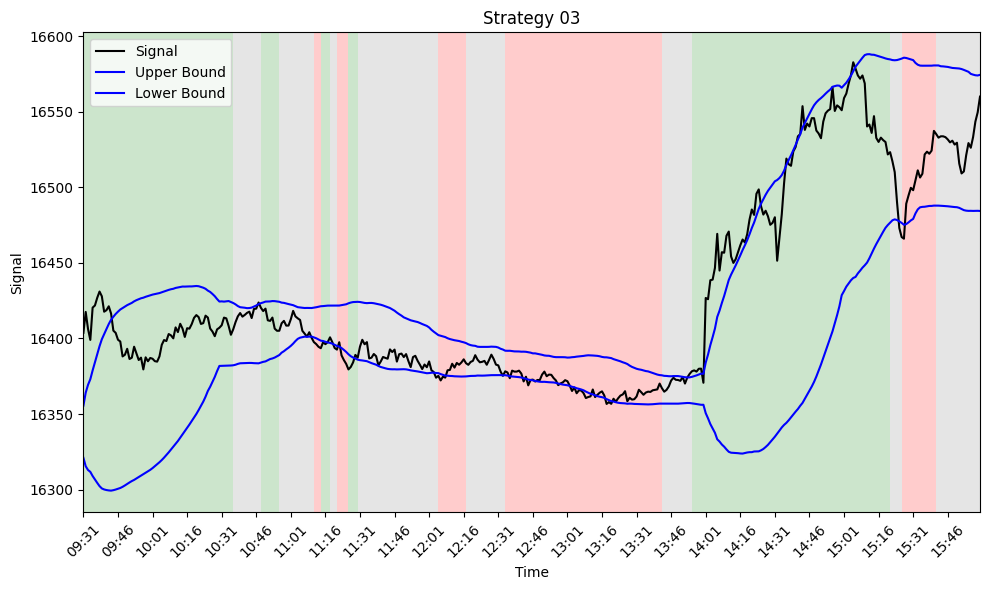

<Axes: title={'center': 'Strategy 03'}, xlabel='Time', ylabel='Signal'>

In [27]:

plot_positions_vb(
    data_plot=dataQ4,
    date_plot="2023-12-13",
    col_signal="NQ",
    col_upper="upper_1",
    col_lower="lower_1",
    col_pos="position_3",
    title="Strategy 03"
)